# **NLP Notebook - HW1 (2021)**
### *Andrea Trianni  - 1806198*
---
This notebook covers the entire machine learning pipeline for the HW1 of the NLP course. The topic is Word Sense Disambiguation.

Into this notebook i will make a strong use of the classes defined into /hw1/stud folder, designed by me. 

Examples of these classes are: TextDataset, Vocabuary, TextProcessor, Classifiers, ..

Information and documentation about that can be founded into *.py code file.

During this notebook, i will first visualize and process the data (step by step), train my own models, and collect the results. Other information will be provided during the notebook chapters.

The best weights will be used and re-loaded from disk to predict the labels of the test dataset.




## 0. First steps

Into this section i will do preliminaries operations:

In [1]:
# Mount private-drive folder  (Optional --> Colab GPU)
# Pay attention to C.W.D. to use relative path in the rest of the notebook

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/hw1-nlp/hw1/
!nvidia-smi

Mounted at /content/drive
/content/drive/MyDrive/hw1-nlp/hw1
Wed Apr 28 21:02:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                           

In [2]:
# Import allowed libraries

from stud.Vocabulary import Vocabulary
from stud.TextDataset import TextDataset
from stud.NeuralNetworks import MLPClassifier, LSTMClassifier
from stud.TextProcessor import TextProcessor
from stud.implementation import *

import json
import copy
import re
import collections
import random

import matplotlib.pyplot as plt
import numpy as np
import nltk
import torch

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Relative path declaration

DATASET_TRAINING_PATH = "../data/train.jsonl"
DATASET_VALIDATION_PATH = "../data/dev.jsonl"

GLOVE_50D_PATH = "../data/glove.6B.50d.txt"
GLOVE_300D_PATH = "../data/glove.6B.300d.txt"

## 1. Data Visualization

Into this section i will visualize the data and collect interesting plots that will be added into the PDF report.



In [ ]:
dataset = TextDataset.from_disk(DATASET_TRAINING_PATH,DATASET_VALIDATION_PATH)
tp      = TextProcessor(None)

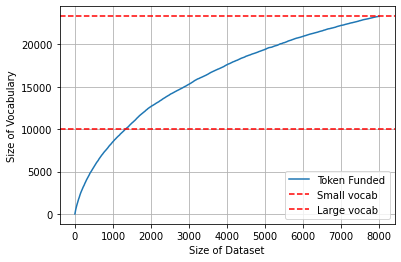

In [ ]:
# Plots vocabulary size respect size of dataset

history=[0]
tokens = set()

for sample in dataset:
  new_tokens = tp.text_to_tokens(sample['x1_data'] +" "+ sample['x2_data'])
  for token in new_tokens:
    tokens.add(token)
  history += [len(tokens)]

fig = plt.figure(); ax = plt.axes()
ax.plot([x for x in range(0,len(history))], history, label='Token Funded');
plt.axhline(y=10000, color='r', linestyle='--', label='Small vocab')
plt.axhline(y=23300, color='r', linestyle='--', label='Large vocab')
plt.ylabel("Size of Vocabulary");  plt.xlabel("Size of Dataset")
ax.legend()
plt.grid()
plt.show()

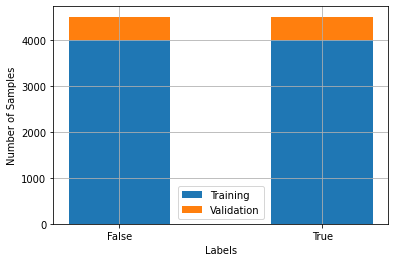

In [ ]:
# Plots a bar chart to summarize info about sizes of classes and sets of the data

train_counts={}
val_counts={}

dataset.set_split("train")
for sample in dataset:
  train_counts[sample['y_target']] = train_counts.get(sample['y_target'], 0) + 1

dataset.set_split("val")
for sample in dataset:
  val_counts[sample['y_target']] = val_counts.get(sample['y_target'], 0) + 1


fig = plt.figure(); ax = plt.axes()
ax.bar(["False","True"], [train_counts[0],train_counts[1]], width=0.5, label="Training")
ax.bar(["False","True"], [val_counts[0],val_counts[1]], bottom=[train_counts[0],train_counts[1]],  width=0.5, label="Validation")
plt.ylabel("Number of Samples");  plt.xlabel("Labels")
ax.legend()
plt.grid()
plt.show()

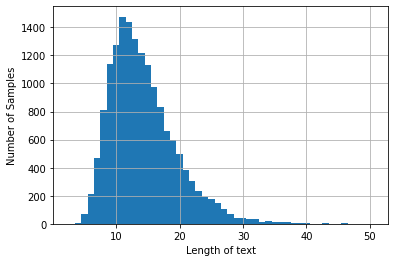

In [ ]:
# Histogram of sentence lengths

lengths = collections.OrderedDict()

dataset.set_split("train")
for sample in dataset:
  tokens1 = tp.text_to_tokens(sample['x1_data'])
  tokens2 = tp.text_to_tokens(sample['x2_data'])
  lengths[len(tokens1)] = lengths.get(len(tokens1), 0) + 1
  lengths[len(tokens2)] = lengths.get(len(tokens2), 0) + 1

fig = plt.figure(); ax = plt.axes()
ax.bar(lengths.keys(), lengths.values(), width=1)
plt.ylabel("Number of Samples");  plt.xlabel("Length of text")
plt.grid()
plt.show()

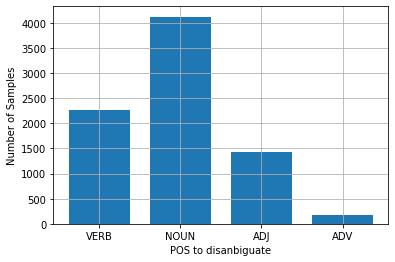

In [ ]:
# Distribution of POS respect lemma to disambiguate

pos_count = {}

dataset.set_split("train")
for sample in dataset:
    pos_count[sample['pos']] = pos_count.get(sample['pos'], 0) + 1

fig = plt.figure(); ax = plt.axes()
ax.bar(pos_count.keys(), pos_count.values(), width=0.75)
plt.ylabel("Number of Samples");  plt.xlabel("POS to disanbiguate")
plt.grid()
plt.show()

## 2. Data Processing Pipeline

### 2.1 Building the vocabularies

Now i am going to build some vocabularies of different sizes. This is due to the fact that i am going to search the best tradeoff between bias and variance in my models. So is not obliovus that a bigger vocabularies guarantee an higher accuracy. Vocabularies are built starting only from training set, so there isn't any risk of information leakage.

In [ ]:
# Build vocabulary from training dataset

def build_vocabulary_from_dataset (dataset, max_size=50000):
  
  tp     = TextProcessor(None)
  tokens = collections.OrderedDict()
  
  for sample in dataset:
      new_tokens =  tp.text_to_tokens(sample['x1_data'])
      new_tokens += tp.text_to_tokens(sample['x2_data'])
      for token in new_tokens:
        tokens[token] = tokens.get(token, 0) + 1

  voc = Vocabulary(max_size=max_size, unk=True, pad=True, sep=True)
  for token,count in tokens.items():
      voc.add_token(token)

  voc.to_disk("../model/Vocabulary_"+str(len(voc))+"TOK.json")


In [ ]:
dataset = TextDataset.from_disk(DATASET_TRAINING_PATH,DATASET_VALIDATION_PATH)
dataset.set_split("train")

build_vocabulary_from_dataset(dataset,23300)
build_vocabulary_from_dataset(dataset,10000)

### 2.2 Process the embeddings

As far as for the vocabularies, in this section i am going to process different size of pretrained glove embedding: 50D and 300D. I am going to take a subset of the original file, only for the words of my vocabularies.

To correctly run this cells is expected to have into ./data folder the glove files. They can be downloaded from http://nlp.stanford.edu/data/glove.6B.zip also using !wget

In [ ]:
# Retrieve embeddings from vocabulary (subset)

def get_embeddings_from_vocabulary(vocabulary, embedding_path):

  idx = 0; word2idx = {}; embeddings = []

  with open(embedding_path, 'rb') as f:
      lines = f.readlines()
      for l in lines:
          line = l.decode().split(" ")
          word2idx[line[0]] = idx;  idx += 1
          vect = np.array(line[1:]).astype(np.float)
          embeddings.append(vect)

  embedding_size = len(embeddings[0])
  embeddings=np.array(embeddings)
  vocab_embedding= np.zeros((len(vocabulary),embedding_size))

  for word, index in vocabulary.tokens.items():
      if word in word2idx:
          vocab_embedding[int(index)] = embeddings[word2idx[word]]
      else:
          random_emb =torch.nn.init.xavier_uniform_(torch.ones(1,embedding_size))
          vocab_embedding[int(index)] = random_emb

  with open("../model/embedding_"+str(embedding_size)+"D_"+str(len(vocabulary))+"TOK.json", "w") as fp:
    json.dump(vocab_embedding.tolist(), fp)


In [ ]:
voc10k = Vocabulary.from_disk("../model/Vocabulary_10000TOK.json")
voc23k = Vocabulary.from_disk("../model/Vocabulary_23300TOK.json")

get_embeddings_from_vocabulary (voc10k, GLOVE_300D_PATH)
get_embeddings_from_vocabulary (voc23k, GLOVE_300D_PATH)
get_embeddings_from_vocabulary (voc10k, GLOVE_50D_PATH)
get_embeddings_from_vocabulary (voc23k, GLOVE_50D_PATH)

## 3. Training Stage

After the process of the text it is now time to start train, i will try different models to find the best.

The architectures are : MLP, LSTM

The embedding sizes are: 50, 300

The vocabulary sizes are: 10k, 23k

So i am going to train 2 * 2 * 2 = 8 Models.

Each model will be trained using a small grid search over batch size and learning rate.

### 3.1 Setting the enviroment


In [4]:
# Function to perform grid search

def grid_search_training (studentmodel, learning_rate=[0.001, 0.0005], batch_size=[16,32], max_epoch=100):

  print('GRID SEARCH TRAINING -- ' + str(studentmodel)+"\n")

  best_setting = { 'weight':None,'train_log':{},'val_log':{'loss':[99]},'bs':0,'lr':0 }

  for lr in learning_rate:
    for bs in batch_size:
    
      train_log, val_log = sm.train_network(lr, bs, max_epoch, verbose=False)

      i = np.argmin(val_log['loss'])
      print('Batch Size: '+ str(bs) + ' Learning Rate: '+ str(lr) + ' Epochs:'+ str(len(train_log['loss'])) +' -- Loss: '+ str(round(val_log['loss'][i],4)) +'  Accuracy:'+ str(round(val_log['acc'][i],4)) )

      if min(best_setting['val_log']['loss']) > min(val_log['loss']):
        best_setting['bs'] = bs; best_setting['lr'] = lr;
        best_setting['val_log'] = val_log; best_setting['train_log'] = train_log
        best_setting['weight'] = copy.deepcopy(studentmodel.classifier.state_dict())

      studentmodel.classifier.weight_reset()

  torch.save(best_setting['weight'], "../model/"+str(studentmodel)+".pth")
  studentmodel.classifier.load_state_dict(torch.load("../model/"+str(studentmodel)+".pth"))

  i = np.argmin(best_setting['val_log']['loss'])
  print("\nBest settings are: Batch size="+ str(best_setting['bs']) + "  Learning Rate="+ str(best_setting['lr'])+"  Epochs="+str(len(best_setting['train_log']['loss']))   )   
  print("Scores: Accuracy="+str(round(best_setting['val_log']['acc'][i],4)) +" Loss="+str(round(best_setting['val_log']['loss'][i],4)) 
        +" F1="+ str(round(best_setting['val_log']['f1'][i],4)) +" Precision="+ str(round(best_setting['val_log']['prec'][i],4)) +" Recall="+ str(round(best_setting['val_log']['recall'][i],4)) +"\n")   

  return best_setting['train_log'], best_setting['val_log']


In [5]:
# Plot the logs of train and validation

def plot_train_log(model_name, train_acc, train_loss, val_acc, val_loss):
  plt.plot(train_acc) ; plt.plot(val_acc)
  plt.ylabel('Accuracy') ; plt.xlabel('Epoch')
  plt.title(model_name)
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

  plt.plot(train_loss) ; plt.plot(val_loss)
  plt.ylabel('Loss') ; plt.xlabel('Epoch')
  plt.title(model_name)
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

In [6]:
# Reload all the stuff to start train ..

dataset = TextDataset.from_disk(DATASET_TRAINING_PATH,DATASET_VALIDATION_PATH)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

voc10k = Vocabulary.from_disk("../model/Vocabulary_10000TOK.json")
voc23k = Vocabulary.from_disk("../model/Vocabulary_23300TOK.json")

tp10k = TextProcessor(voc10k)
tp23k = TextProcessor(voc23k)

with open("../model/embedding_50D_23300TOK.json") as fp:
  embedding_23k_50d = torch.tensor(json.load(fp)).to(device)

with open("../model/embedding_50D_10000TOK.json") as fp:
  embedding_10k_50d = torch.tensor(json.load(fp)).to(device)

with open("../model/embedding_300D_23300TOK.json") as fp:
  embedding_23k_300d = torch.tensor(json.load(fp)).to(device)

with open("../model/embedding_300D_10000TOK.json") as fp:
  embedding_10k_300d = torch.tensor(json.load(fp)).to(device)

### 3.2 MLP Model

In this section there are the training cells for MLP Models.

GRID SEARCH TRAINING -- MLP_50D_10000TOK

Batch Size: 16 Learning Rate: 0.001 Epochs:32 -- Loss: 0.6662  Accuracy:0.5837
Batch Size: 32 Learning Rate: 0.001 Epochs:27 -- Loss: 0.6576  Accuracy:0.6089
Batch Size: 16 Learning Rate: 0.0005 Epochs:45 -- Loss: 0.6516  Accuracy:0.6351
Batch Size: 32 Learning Rate: 0.0005 Epochs:44 -- Loss: 0.6554  Accuracy:0.6139

Best settings are: Batch size=16  Learning Rate=0.0005  Epochs=45
Scores: Accuracy=0.6351 Loss=0.6516 F1=0.6239 Precision=0.6389 Recall=0.6375



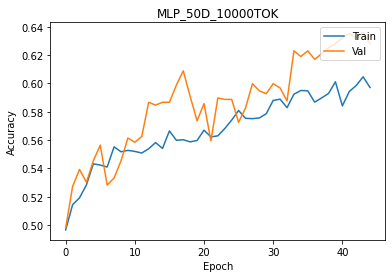

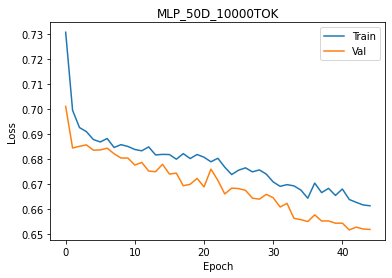

In [ ]:
MLPclassifier = MLPClassifier(50,50,len(voc10k),voc10k.pad_index,embedding_10k_50d)
sm = StudentModel(MLPclassifier, dataset, tp10k, device)

train_log, val_log = grid_search_training(sm)
plot_train_log (str(sm), train_log['acc'], train_log['loss'], val_log['acc'], val_log['loss'])

GRID SEARCH TRAINING -- MLP_50D_23300TOK

Batch Size: 16 Learning Rate: 0.001 Epochs:29 -- Loss: 0.6391  Accuracy:0.6361
Batch Size: 32 Learning Rate: 0.001 Epochs:27 -- Loss: 0.6456  Accuracy:0.629
Batch Size: 16 Learning Rate: 0.0005 Epochs:40 -- Loss: 0.6487  Accuracy:0.626
Batch Size: 32 Learning Rate: 0.0005 Epochs:39 -- Loss: 0.6317  Accuracy:0.6411

Best settings are: Batch size=32  Learning Rate=0.0005  Epochs=39
Scores: Accuracy=0.6411 Loss=0.6317 F1=0.63 Precision=0.6467 Recall=0.6415



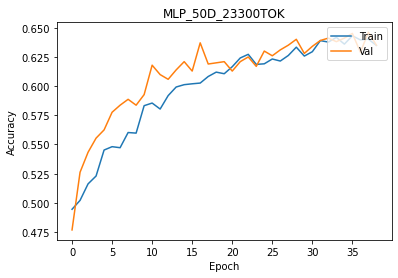

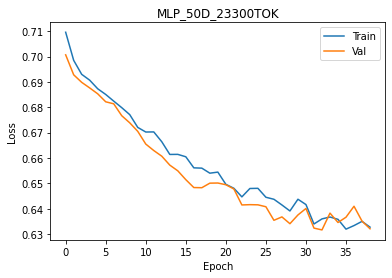

In [ ]:
MLPclassifier = MLPClassifier(50,50,len(voc23k),voc23k.pad_index,embedding_23k_50d)
sm = StudentModel(MLPclassifier, dataset, tp23k, device)

train_log, val_log = grid_search_training(sm)
plot_train_log (str(sm), train_log['acc'], train_log['loss'], val_log['acc'], val_log['loss'])

GRID SEARCH TRAINING -- MLP_300D_10000TOK

Batch Size: 16 Learning Rate: 0.001 Epochs:14 -- Loss: 0.6516  Accuracy:0.6069
Batch Size: 32 Learning Rate: 0.001 Epochs:17 -- Loss: 0.6493  Accuracy:0.623
Batch Size: 16 Learning Rate: 0.0005 Epochs:20 -- Loss: 0.6523  Accuracy:0.6018
Batch Size: 32 Learning Rate: 0.0005 Epochs:16 -- Loss: 0.6425  Accuracy:0.6028

Best settings are: Batch size=32  Learning Rate=0.0005  Epochs=16
Scores: Accuracy=0.6028 Loss=0.6425 F1=0.5914 Precision=0.5989 Recall=0.5987



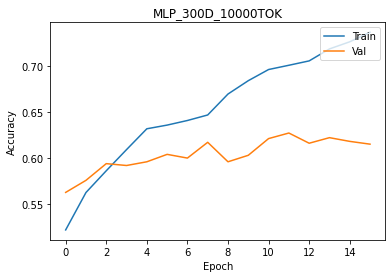

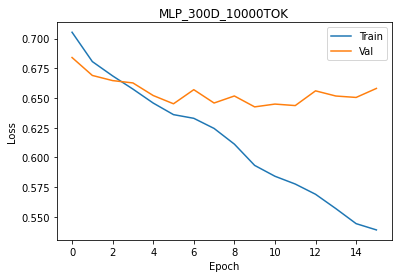

In [ ]:
MLPclassifier = MLPClassifier(300,300,len(voc10k),voc10k.pad_index,embedding_10k_300d)
sm = StudentModel(MLPclassifier, dataset, tp10k, device)

train_log, val_log = grid_search_training(sm)
plot_train_log (str(sm), train_log['acc'], train_log['loss'], val_log['acc'], val_log['loss'])

GRID SEARCH TRAINING -- MLP_300D_23300TOK

Batch Size: 16 Learning Rate: 0.001 Epochs:15 -- Loss: 0.6384  Accuracy:0.621
Batch Size: 32 Learning Rate: 0.001 Epochs:14 -- Loss: 0.6374  Accuracy:0.622
Batch Size: 16 Learning Rate: 0.0005 Epochs:20 -- Loss: 0.6465  Accuracy:0.624
Batch Size: 32 Learning Rate: 0.0005 Epochs:15 -- Loss: 0.649  Accuracy:0.5948

Best settings are: Batch size=32  Learning Rate=0.001  Epochs=14
Scores: Accuracy=0.622 Loss=0.6374 F1=0.6152 Precision=0.6255 Recall=0.6257



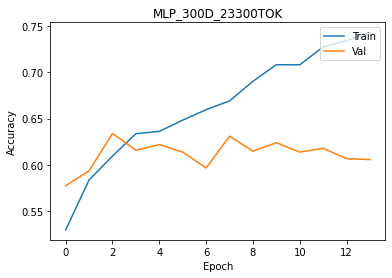

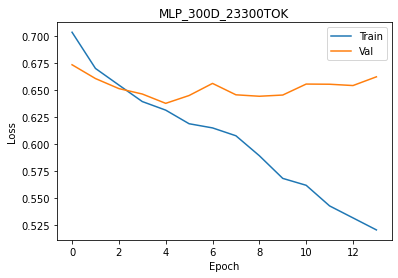

In [ ]:
MLPclassifier = MLPClassifier(300,300,len(voc23k),voc23k.pad_index,embedding_23k_300d)
sm = StudentModel(MLPclassifier, dataset, tp23k, device)

train_log, val_log = grid_search_training(sm)
plot_train_log (str(sm), train_log['acc'], train_log['loss'], val_log['acc'], val_log['loss'])

### 3.3 LSTM Model

In this section there are the training cells for LSTM Models.

GRID SEARCH TRAINING -- LSTM_50D_10000TOK

Batch Size: 16 Learning Rate: 0.001 Epochs:19 -- Loss: 0.6434  Accuracy:0.6079
Batch Size: 32 Learning Rate: 0.001 Epochs:21 -- Loss: 0.6417  Accuracy:0.63
Batch Size: 16 Learning Rate: 0.0005 Epochs:17 -- Loss: 0.6511  Accuracy:0.5988
Batch Size: 32 Learning Rate: 0.0005 Epochs:25 -- Loss: 0.6554  Accuracy:0.5766

Best settings are: Batch size=32  Learning Rate=0.001  Epochs=21
Scores: Accuracy=0.63 Loss=0.6417 F1=0.6219 Precision=0.6306 Recall=0.6297



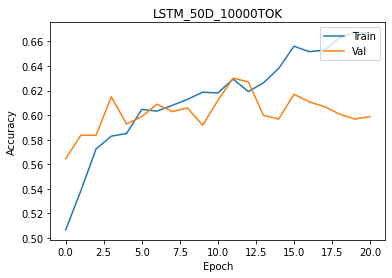

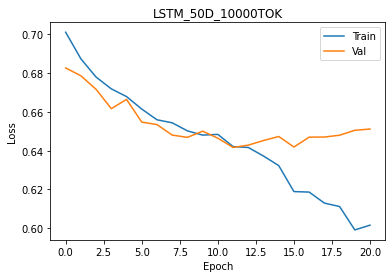

In [ ]:
LSTMclassifier = LSTMClassifier(50,50,len(voc10k),voc10k.pad_index,embedding_10k_50d)
sm = StudentModel(LSTMclassifier, dataset, tp10k, device)

train_log, val_log = grid_search_training(sm)
plot_train_log (str(sm), train_log['acc'], train_log['loss'], val_log['acc'], val_log['loss'])

GRID SEARCH TRAINING -- LSTM_50D_23300TOK

Batch Size: 16 Learning Rate: 0.001 Epochs:23 -- Loss: 0.6221  Accuracy:0.6472
Batch Size: 32 Learning Rate: 0.001 Epochs:19 -- Loss: 0.6275  Accuracy:0.628
Batch Size: 16 Learning Rate: 0.0005 Epochs:30 -- Loss: 0.635  Accuracy:0.6008
Batch Size: 32 Learning Rate: 0.0005 Epochs:28 -- Loss: 0.6441  Accuracy:0.6129

Best settings are: Batch size=16  Learning Rate=0.001  Epochs=23
Scores: Accuracy=0.6472 Loss=0.6221 F1=0.629 Precision=0.6563 Recall=0.6489



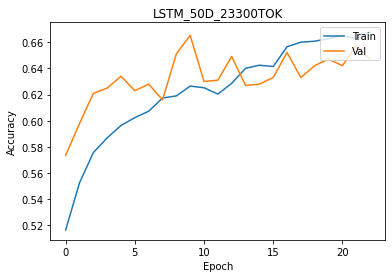

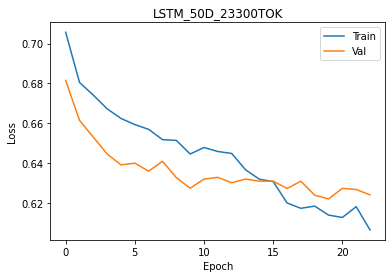

In [7]:
LSTMclassifier = LSTMClassifier(50,50,len(voc23k),voc23k.pad_index,embedding_23k_50d)
sm = StudentModel(LSTMclassifier, dataset, tp23k, device)

train_log, val_log = grid_search_training(sm)
plot_train_log (str(sm), train_log['acc'], train_log['loss'], val_log['acc'], val_log['loss'])

GRID SEARCH TRAINING -- LSTM_300D_10000TOK

Batch Size: 16 Learning Rate: 0.001 Epochs:18 -- Loss: 0.6581  Accuracy:0.5917
Batch Size: 32 Learning Rate: 0.001 Epochs:12 -- Loss: 0.6672  Accuracy:0.5827
Batch Size: 16 Learning Rate: 0.0005 Epochs:12 -- Loss: 0.66  Accuracy:0.6028
Batch Size: 32 Learning Rate: 0.0005 Epochs:13 -- Loss: 0.6671  Accuracy:0.5756

Best settings are: Batch size=16  Learning Rate=0.001  Epochs=18
Scores: Accuracy=0.5917 Loss=0.6581 F1=0.5727 Precision=0.591 Recall=0.5879



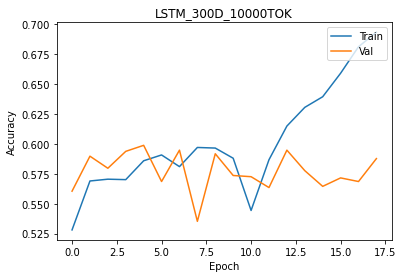

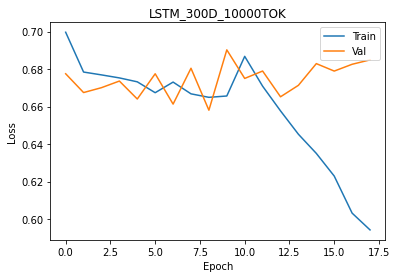

In [ ]:
LSTMclassifier = LSTMClassifier(300,300,len(voc10k),voc10k.pad_index,embedding_10k_300d)
sm = StudentModel(LSTMclassifier, dataset, tp10k, device)

train_log, val_log = grid_search_training(sm)
plot_train_log (str(sm), train_log['acc'], train_log['loss'], val_log['acc'], val_log['loss'])

GRID SEARCH TRAINING -- LSTM_300D_23300TOK

Batch Size: 16 Learning Rate: 0.001 Epochs:15 -- Loss: 0.6443  Accuracy:0.6159
Batch Size: 32 Learning Rate: 0.001 Epochs:12 -- Loss: 0.6558  Accuracy:0.6008
Batch Size: 16 Learning Rate: 0.0005 Epochs:12 -- Loss: 0.6596  Accuracy:0.6008
Batch Size: 32 Learning Rate: 0.0005 Epochs:12 -- Loss: 0.6517  Accuracy:0.5978

Best settings are: Batch size=16  Learning Rate=0.001  Epochs=15
Scores: Accuracy=0.6159 Loss=0.6443 F1=0.6027 Precision=0.616 Recall=0.6108



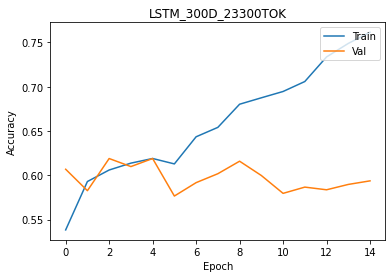

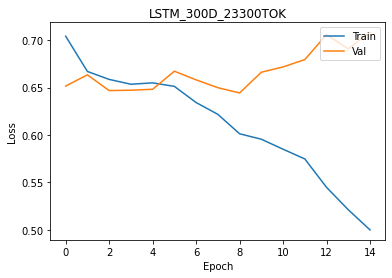

In [ ]:
LSTMclassifier = LSTMClassifier(300,300,len(voc23k),voc10k.pad_index,embedding_23k_300d)
sm = StudentModel(LSTMclassifier, dataset, tp23k, device)

train_log, val_log = grid_search_training(sm)
plot_train_log (str(sm), train_log['acc'], train_log['loss'], val_log['acc'], val_log['loss'])

## 4. Conclusions

During the grid search we selected the model with the lowest loss, but after training all the models now we have to understand which is the best for the MLP architecture and which is the best for the LSTM architecture. In this case the choice criterion was to select the one with the best accuracy, as the performance of the model in the test set will be evaluated with that metric. 

The best of these two will then be selected as the final model. 